## Friend-to-friendネットワークにおける効率的な分散ルーティング

#### 非線形物理学講座　理論神経科学・非平衡系数理グループ
#### B4髙橋彰

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from math import log
import random, logging, sys

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

from utils.gen import kleinberg_ring
from utils.search import greedy_path, average_greedy_path_length, RoutingError
from utils.misc import shuffle_position_ring, dist_ring, labels_from_attr

logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, stream=sys.stderr)

def draw_autocrop(G):
    pos = nx.circular_layout(G)
    cut = 1.05
    xmax= cut*max(xx for xx,yy in pos.values())
    ymax= cut*max(yy for xx,yy in pos.values())
    plt.xlim(-xmax,xmax)
    plt.ylim(-ymax,ymax)
    return pos
def draw_autocrop_grid(G):
    pos = dict(zip(G,G))
    cut = 1.05
    xmax= cut*max(xx for xx,yy in pos.values())
    ymax= cut*max(yy for xx,yy in pos.values())
    plt.xlim(-0.3,xmax)
    plt.ylim(-0.3,ymax)
    return pos

# 1. 研究の背景

## 1.1 背景: 複雑ネットワークにおけるルーティング
- Small-world network - Watts, Strogatz(1998)
    - 高いクラスタリング係数: $CC$
    - 小さな平均最短経路長: $O(\log n)$
    - 送電網、脳神経、友人関係のネットワーク等現実世界の様々なネットワーク構造に現れる特徴
    
- Navigable small-world network - Kleinberg(2000)
    - 分散的かつ効率的なルーティングを可能にするスモール・ワールドネットワークのモデル
    - P2Pネットワークにおけるルーティングアルゴリズムに応用可能

## 1.1 背景: 複雑ネットワークにおけるルーティング **TODO**
- Scale-free network - Barabasi, Albert(1999) **TODO**
- Routing in scale-free networks - **TODO**: who?

## 1.2 背景: P2Pネットワーク　**TODO**
- P2Pネットワークのメリット
    - 負荷分散
    - 匿名化
    - 耐障害性

## 1.3 背景: F2Fネットワーク
- Friend-to-friend(F2F)network, Darknet - Clarke et.al(2000, 2009)
    - P2Pネットワークの一形態
    - ネットワーク上の各ノードは、信頼のおける特定ノードとのみ直接の通信を行う
    - 匿名性やプライバシーコントロールレベルの向上を目的とする
    - ネットワーク上で隣接していないノード同士がデータの送受信を行うために複数ノードを中継(c.f. プロキシ)
    - 知り合い関係のネットワークがスモール・ワールド性を持つことを利用
    - Opennet vs Darknet: **TODO**
    - 実装例: Freenet 0.7 or 0.7.5, Retroshare, GNUNet
- F2Fネットワークの課題: **TODO**
    1. 効率性
        - 現実のネットワークトポロジーと理想的なモデルの相違からルーティングが失敗する場合がある
    2. 安全性
        - アタッカーノードの存在を仮定した場合、安全性が保たれない
    3. 頑健性
        - 実際のネットワークは静的でなく、動的にノードが出入りする(=churn)場合、ルーティングの効率性が保証されない - Evans(2007)
- 本研究ではF2Fネットワークにおけるルーティングの**効率性**の向上を目指す

# 2. 先行研究の紹介

## 2.1 Navigable small-world network model (Kleinberg, 2000)
### 2.1.1 概要
- Milgramの実験(1961)では各ノードがネットワーク全体の構造を知らずとも少ないホップ数でメッセージをターゲットまで届けることができた
- **分散ルーティング**: 各ノードが局所的な情報のみを利用して次にメッセージを渡すべきノードを決定するルーティング
- Kleinberg(2000)は分散ルーティング可能なスモール・ワールドネットワークの単純なモデルを提唱
- $u,v$間のエッジ存在確率$\propto d(u,v)^{-r}$
- $r$の値が格子の次元に一致する時、シンプルな分散ルーティング(各ノードは隣接ノードの中でターゲットに一番近いノードを選択)により$O(\log^2 n)$のホップ数で高確率でターゲットまで辿り着ける

## 2.1 Navigable small-world network model (Kleinberg, 2000) 
### 2.1.2 グラフ生成アルゴリズム:
1. サイズ$n$の$k$次元格子$G$を初期状態とする
2. 各ノードは隣接ノードとのエッジを持つ(local contact)
3. $\forall u \in G$に対し$q$本の長距離エッジ(long-range contact)を追加する。ただし$u$が$v$とのエッジを持つ確率を$p(u,v)$として、$p(u,v) \propto d(u,v)^{-r}$とする
    - $r$: パラメータ
    - $d(u,v)$: $u,v$間の格子上距離

## 2.1 Navigable small-world network model (Kleinberg, 2000) 
### 2.1.3 分散ルーティング
- ネットワーク全体の状態を把握するノードが存在しないルーティング
    - 対義語: 中央集権的ルーティング (例: Dijkstra法)

## 2.1 Navigable small-world network model (Kleinberg, 2000) 
### 2.1.4 3つの定理
1. For $0 \leq r < k$, the delivery time of any decentralized algorithm in the grid-based model is $\Omega(n^{(2-r)/3)})$
2. For $r=k$, there is a decentralized algorithm with delivery time $O(\log^2 n)$
3. For $k \leq r$, the delivery time of any decentralized algorithm in the grid-based model is $\Omega(n^{(r-2)/(r-1))})$

## 2.1 Navigable small-world network model (Kleinberg, 2000) 
### 2.1.5 例: 2次元の場合

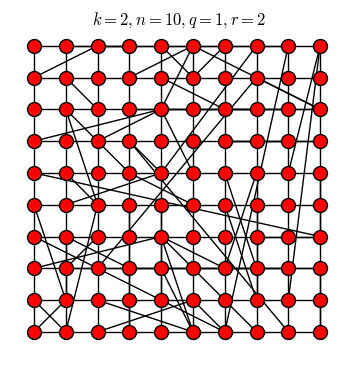

In [15]:
plt.rcParams['figure.figsize'] = (4,4)
G = nx.navigable_small_world_graph(10, p=1, q=1, r=2, dim=2)
G = G.to_undirected()
pos=draw_autocrop_grid(G)
plt.title("$k=2, n=10, q=1, r=2$")
nx.draw(G, pos=dict(zip(G,G)), node_size=100, node_color='r')

## 2.1 Navigable small-world network model (Kleinberg, 2000) 
### 2.1.5 例: 1次元の場合

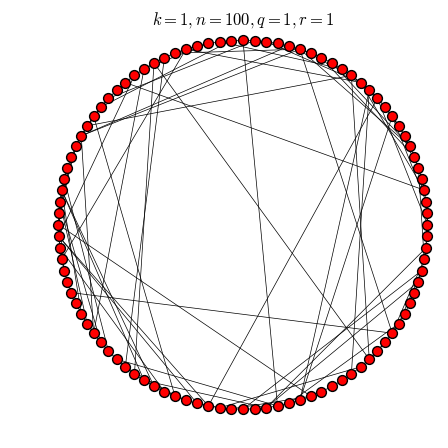

In [14]:
plt.rcParams['figure.figsize'] = (5,5)
G = kleinberg_ring(100, p=1, q=1, r=1)
pos = draw_autocrop(G)
plt.title("$k=1, n=100, q=1, r=1$") 
nx.draw_circular(G, with_labels=False, node_size=50, node_color='r', width=0.5)

## 2.2 Application to the routing in F2F overlay networks (Sandberg, 2005)
### 2.2.1 概要 Overview
- スモール・ワールドネットワーク上でのルーティング→P2Pオーバーレイネットワーク上でのルーティング
- 信頼関係によるF2Fネットワークを構築した場合スモール・ワールド性を持つと仮定(例: Web of Trust)
- Kleinberg(2000)では各ノードが自分の格子上での位置を知っていることが前提となっている
    - コンピュータのオーバーレイネットワークではこの前提が成り立たない
    - 各ノードに格子上の位置を知らせる必要がある
- 元のグラフを格子状に配置し、Kleinbergのモデルに従った場合尤も生起する確率が高くなるような**配置**をMCMCにより求める
    - ノードの格子状における位置をそのノードのIDとする

## 2.2 Application to the routing in F2F overlay networks (Sandberg, 2005)
### 2.2.2 問題設定
- $P(E|\phi)$を最大にするような$\phi$を求める

## 2.2 Application to the routing in F2F overlay networks (Sandberg, 2005)
### 2.2.3 手法
- Metropolis-Hastingsアルゴリズムによりembedding $\phi$をサンプリング

## 2.2 Application to the routing in F2F overlay networks (Sandberg, 2005)
### 2.2.3 手法
- dead-endに対応するためのルーティングアルゴリズム: C

## 2.2 Application to the routing in F2F overlay networks (Sandberg, 2005)
### 2.2.4 シミュレーション結果
- シャッフル後データ
- PGPの解析
- 分散的に実装可能な提案分布を用いた場合

## 2.2 Application to the routing in F2F overlay networks (Sandberg, 2005)
### 2.2.5 結論

# 3. 追試結果
- Sandberg(2006)の手法を用いた実データの解析結果

# 4. 考察と改良案